In [1]:
# importing important libraries.
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\DELL\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a depre

In [2]:
# import all english stopwords from nltk.
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [33]:
# Importing Dataset
df = pd.read_table("amazon_reviews.txt")
df.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


In [69]:
df.shape

(21000, 9)

In [73]:
df.PRODUCT_CATEGORY.unique().shape

(30,)

In [34]:
#checking unique target names.
df.REVIEW_TITLE.unique()

array(['useful', 'New era for batteries', "doesn't swing very well.", ...,
       'I love moccasins This fit like it was custom made for ...',
       'This fit well, comfortable, best investment',
       'Love these shoes, except for the laces'], dtype=object)

In [74]:
#checking for missing values.
df.isnull().sum()

DOC_ID               0
LABEL                0
RATING               0
VERIFIED_PURCHASE    0
PRODUCT_CATEGORY     0
PRODUCT_ID           0
PRODUCT_TITLE        0
REVIEW_TITLE         0
REVIEW_TEXT          0
dtype: int64

### Text Preprocessing

In [35]:
# Remove emails and newline characters
# Convert to list
data = df.REVIEW_TEXT.dropna().values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

data[:1]

['When least you think so, this product will save the day. Just keep it around just in case you need it for something.']

In [36]:
# Tokenize words and Clean-up text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['when', 'least', 'you', 'think', 'so', 'this', 'product', 'will', 'save', 'the', 'day', 'just', 'keep', 'it', 'around', 'just', 'in', 'case', 'you', 'need', 'it', 'for', 'something']]


In [37]:
# Creating unigrams

In [38]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['when', 'least', 'you', 'think', 'so', 'this', 'product', 'will', 'save', 'the', 'day', 'just', 'keep', 'it', 'around', 'just', 'in', 'case', 'you', 'need', 'it', 'for', 'something']


In [39]:
# Remove Stopwords, Make Bigrams and Lemmatize

In [40]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [41]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


In [42]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [43]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['least', 'think', 'product', 'save', 'day', 'keep', 'case', 'need']]


In [44]:
# create a dictionary which will be the input for LDA model

In [45]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [46]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('case', 1),
  ('day', 1),
  ('keep', 1),
  ('least', 1),
  ('need', 1),
  ('product', 1),
  ('save', 1),
  ('think', 1)]]

# Model building and evaluting.

In [47]:
select_topics = []
for i in [5, 10, 15, 20, 30, 40]:
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=i, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)


    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

    select_topics.append({"No of Topics": i, "Coherence Score": coherence_lda})


Perplexity:  -7.990974934939393

Coherence Score:  0.32589302881090815

Perplexity:  -8.534544594946583

Coherence Score:  0.28412549287018535

Perplexity:  -13.03181495173071

Coherence Score:  0.280103261775939

Perplexity:  -15.464154539725506

Coherence Score:  0.2717598095288652

Perplexity:  -19.142733568516565

Coherence Score:  0.3271923760650157

Perplexity:  -22.85361208983573

Coherence Score:  0.33243272949008096


In [48]:
select_topics_df = pd.DataFrame(select_topics)

In [49]:
select_topics_df

,No of Topics,Coherence Score
0,5,0.325893
1,10,0.284125
2,15,0.280103
3,20,0.271760
4,30,0.327192
5,40,0.332433


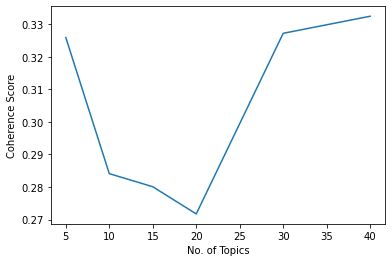

In [50]:
plt.plot(select_topics_df['No of Topics'], select_topics_df['Coherence Score'])
plt.xlabel('No. of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [26]:
# from above table we can see that best model is with no. of tpoics 40.

In [51]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [52]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(22,
  '0.000*"harrison" + 0.000*"hepburn" + 0.000*"fiscal" + 0.000*"fre" + '
  '0.000*"hamstring" + 0.000*"emasculate" + 0.000*"jacqueline" + '
  '0.000*"incompetence" + 0.000*"dapo" + 0.000*"how"'),
 (5,
  '0.000*"harrison" + 0.000*"hepburn" + 0.000*"fiscal" + 0.000*"fre" + '
  '0.000*"hamstring" + 0.000*"emasculate" + 0.000*"jacqueline" + '
  '0.000*"incompetence" + 0.000*"dapo" + 0.000*"how"'),
 (26,
  '0.000*"harrison" + 0.000*"hepburn" + 0.000*"fiscal" + 0.000*"fre" + '
  '0.000*"hamstring" + 0.000*"emasculate" + 0.000*"jacqueline" + '
  '0.000*"incompetence" + 0.000*"dapo" + 0.000*"how"'),
 (14,
  '0.234*"phone" + 0.230*"case" + 0.117*"perfectly" + 0.112*"pocket" + '
  '0.095*"fall" + 0.054*"protect" + 0.042*"slide" + 0.000*"harrison" + '
  '0.000*"kennedys" + 0.000*"hamstring"'),
 (17,
  '0.137*"include" + 0.118*"short" + 0.102*"fun" + 0.068*"instruction" + '
  '0.059*"throw" + 0.054*"list" + 0.050*"tool" + 0.048*"unfortunately" + '
  '0.046*"understand" + 0.043*"plan"'),
 (7,

# Visualize Topics

In [67]:
import pyLDAvis.gensim_models

In [68]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
34     0.293465  0.401147       1        1  25.635626
11     0.133238 -0.150027       2        1   3.731451
15     0.090325 -0.073327       3        1   3.052646
12     0.091344 -0.074535       4        1   3.026451
30     0.095436 -0.079360       5        1   2.970993
3      0.081513 -0.062771       6        1   2.721327
10     0.071542 -0.050917       7        1   2.568225
13     0.057462 -0.036947       8        1   2.551036
31     0.085306 -0.066797       9        1   2.535119
28     0.061409 -0.041022      10        1   2.504556
32     0.053511 -0.033182      11        1   2.490250
23     0.046633 -0.026427      12        1   2.414724
24     0.037309 -0.019942      13        1   2.255386
38     0.025871 -0.012272      14        1   2.252529
4      0.027775 -0.014655      15        1   2.185123
35     0.007243  0.000013      16        1   2.113049
2      0.026303 -0.013496      17        1   2.077829
39     0.004535  0.001012      18        1   2.072559
29     0.019931 -0.009103      19        1   2.068354
8      0.007435 -0.000785      20        1   2.002571
18    -0.003661  0.005319      21        1   1.958449
20    -0.001132  0.004041      22        1   1.916092
16     0.016174 -0.007796      23        1   1.885838
21    -0.006534  0.005893      24        1   1.882469
36     0.000787  0.001840      25        1   1.844975
33     0.054055 -0.034954      26        1   1.824104
25    -0.028384  0.015113      27        1   1.787251
1     -0.008793  0.007552      28        1   1.759577
6     -0.027759  0.015436      29        1   1.661989
9     -0.037444  0.020460      30        1   1.549527
27    -0.003210  0.004505      31        1   1.548381
19    -0.066636  0.029700      32        1   1.308460
37    -0.089112  0.036775      33        1   1.286366
0     -0.079385  0.033943      34        1   1.248226
17    -0.096181  0.038520      35        1   1.173726
7     -0.099240  0.039201      36        1   1.138321
14    -0.056792  0.026223      37        1   0.971311
26    -0.261447  0.040541      38        1   0.008378
5     -0.261447  0.040541      39        1   0.008378
22    -0.261447  0.040541      40        1   0.008378, topic_info=           Term          Freq         Total Category  logprob  loglift
12           br  16423.000000  16423.000000  Default  30.0000  30.0000
38         work   7955.000000   7955.000000  Default  29.0000  29.0000
5       product   5700.000000   5700.000000  Default  28.0000  28.0000
241         fit   5072.000000   5072.000000  Default  27.0000  27.0000
255          go   5258.000000   5258.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
25       market      0.002096    177.816941  Topic40 -10.1735  -1.9613
26        never      0.002096   1627.421941  Topic40 -10.1735  -4.1753
27          new      0.002096   2072.309508  Topic40 -10.1735  -4.4170
28   particular      0.002096    182.768712  Topic40 -10.1735  -1.9888
29        phone      0.002096   1492.260127  Topic40 -10.1735  -4.0886

[1595 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
765      25  0.993928     ability
445      10  0.998478        able
1061     19  0.998042  absolutely
1209     16  0.979549      absorb
1138      5  0.983328   accessory
...     ...       ...         ...
583      30  0.997929       write
982      28  0.996898       wrong
134       1  0.999280        year
976       8  0.997862         yet
804      19  0.995070       young

[794 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[35, 12, 16, 13, 31, 4, 11, 14, 32, 29, 33, 24, 25, 39, 5, 36, 3, 40, 30, 9, 19, 21, 17, 22, 37, 34, 26, 2, 7, 10, 28, 20, 38, 1, 18, 8, 15, 27, 6, 23])

In [54]:
# Finding the dominant topic and its percentage contribution in each document

In [55]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [56]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

In [57]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

In [58]:
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [59]:
df_dominant_topic.Dominant_Topic.value_counts()

34.0    20992
11.0        5
30.0        1
18.0        1
10.0        1
Name: Dominant_Topic, dtype: int64

In [60]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,10.0,0.2097,"watch, game, give, play, unit, deal, plug, mus...","[smoke, hot, deal, second, unit, last, week, w..."
1,11.0,0.3038,"br, book, cover, number, fact, level, child, m...","[salinger, righteous, br, br, scribbling, case..."
2,18.0,0.2330,"light, reason, enjoy, stay, home, sit, mention...","[mask, great, purpose, keeping, light, sure, h..."
3,30.0,0.2082,"need, back, new, return, second, power, send, ...","[company, send, email, purchase, ask, review, ..."
4,34.0,0.4891,"great, get, well, good, buy, love, look, make,...","[love, fit, really, well, driver, seat, use, d..."
